<a href="https://colab.research.google.com/github/mariaberardi/Molecular-Generation/blob/main/MDP_action_definition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Encoding Chemical Reactions using RDKit

We are interested in studying methods to encode chemical reactions. Here we focus on two guiding questions:

1. Many encodings rely on an order of atoms in a compound. This naturally leads to the questions of how to choose an indexing when multiple initial atoms are possible. 

2. The MolDQN algorithm uses three types of actions in the MDP: add an atom, add a bond, remove an atom. A central question is how to test for chemical validy of a compound after adding or removing an atom or after adding a bond.

After loading the necessary libraries, we address both questions. 

In [1]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 29.5 MB 1.7 MB/s 


In [2]:
from rdkit import Chem
from rdkit.Chem import Draw

from rdkit.Chem import RDKFingerprint
from rdkit.Chem import rdMolDescriptors

import numpy as np

import networkx as nx #to represent molecules as graphs
import matplotlib.pyplot as plt

In [39]:
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True  # set this to False if you want PNGs instead of SVGs
IPythonConsole.drawOptions.addAtomIndices = False
from rdkit.Chem import SanitizeMol
from rdkit.Chem import GetMolFrags

## Choosing an Ordering of Atoms

Let's consider two molecules as examples. We first use the standard graph, with unlabeled indexes. 

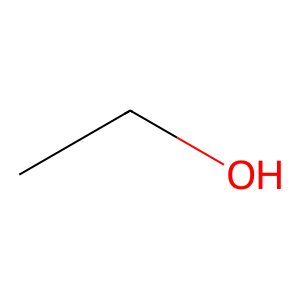

In [22]:
# mol1 does not contain a ring
ethanol_smiles = 'CCO'
mol1 = Chem.MolFromSmiles(ethanol_smiles)
mol1

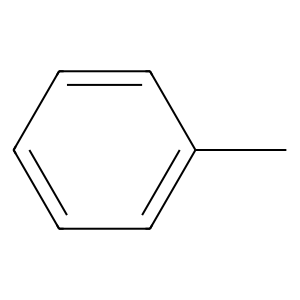

In [23]:
# mol2 contains a ring
toluene_smiles = 'CC1=CC=CC=C1'
mol2 = Chem.MolFromSmiles(toluene_smiles)
mol2

We present two methods to obtain numberings for atoms in molecules. These give the same numberings, displayed in different ways. We first perform them, then given some details on the choice of orderings done behind the scenes. 

In [24]:
# define a function to assign an index to each atom
# uses the GetAtoms() and SetAtomMapNum() functions built into RDKit

def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

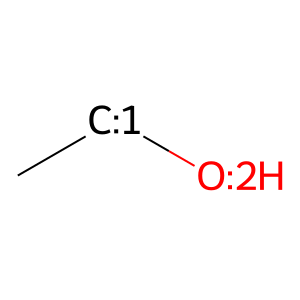

In [25]:
# display mol with atom indexes
mol_with_atom_index(mol1)

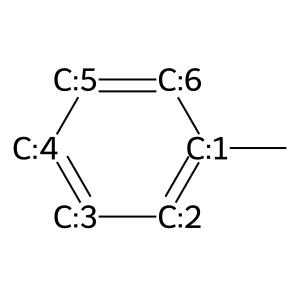

In [26]:
mol_with_atom_index(mol2)

The second method follows. 

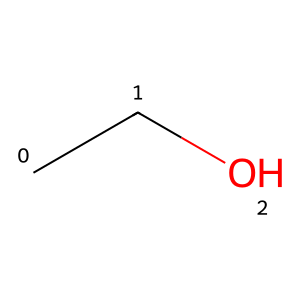

In [27]:
# alternative way to add indexes
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 300,300

# display mol with atom indexes next to atoms
ethanol_smiles = 'CCO'
mol1 = Chem.MolFromSmiles(ethanol_smiles)
mol1

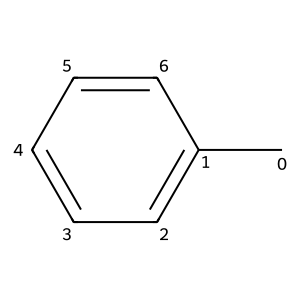

In [28]:
toluene_smiles = 'CC1=CC=CC=C1'
mol2 = Chem.MolFromSmiles(toluene_smiles)
mol2

We now give some background on how RDKit determines which atom gets chosen to be numbered 0, 1, 2 ... respectively. For a detailed explanation, a good source is *Molecular representations in AI-driven drug discovery: a review and practical guide* (L. David, A. Thakkar, R. Mercado, O. Engkvist), which can be found at https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00460-5 We summarize the key points. 



*   This choice is made using a Graph Traversal Algorithm. Common graph traversal algorithms are depth-first or breadth-first. 
*   These do not apply for multi-valent bonds. Hypergraphs offer a possible solution if we want to consider this scenario. (See https://arxiv.org/abs/2203.08031)
*   Hydrogens can be treated as nodes, but are most commonly treated as properties of the heavy atoms, to reduce the size of the encoded vector or matrix. This is the approach taken in the examples above. 



**Remarks on SMILES representations**

* The SMILES representation is non-unique and unambiguous. 
* It is obtained by assigning a number to each atom and then traversing the molecule in the order given by such numbering. 
* RDKit by default uses a **depth-first** algorithm in this case. This can be verified in the two examples above, and also answers the question of why we obtain the same numbering from the two different methods we used. 
* Randomized SMILES representations exist and have applications (first atom selected at random, then follow a pre-defined traversal algorithm). We will not adopt this method for our purposes. 

## Chemical Validy after an Action in the MDP

### A bond addition example

An example from the RDKit documentation (https://www.rdkit.org/docs/Cookbook.html#organometallics-with-dative-bonds):

Author: Greg Landrum

Source: https://sourceforge.net/p/rdkit/mailman/message/36727044/ and https://gist.github.com/greglandrum/6cd7aadcdedb1ebcafa9537e8a47e3a4

Index ID#: RDKitCB_19

Summary: Process organometallic SMILES by detecting single bonds between metals and replacing with dative bonds.

In [43]:
def is_transition_metal(at):
    n = at.GetAtomicNum()
    return (n>=22 and n<=29) or (n>=40 and n<=47) or (n>=72 and n<=79)

In [42]:
def set_dative_bonds(mol, fromAtoms=(7,8)):
    """ convert some bonds to dative

    Replaces some single bonds between metals and atoms with atomic numbers in fomAtoms
    with dative bonds. The replacement is only done if the atom has "too many" bonds.

    Returns the modified molecule.

    """
    pt = Chem.GetPeriodicTable()
    rwmol = Chem.RWMol(mol)
    rwmol.UpdatePropertyCache(strict=False)
    metals = [at for at in rwmol.GetAtoms() if is_transition_metal(at)]
    for metal in metals:
        for nbr in metal.GetNeighbors():
            if nbr.GetAtomicNum() in fromAtoms and \
               nbr.GetExplicitValence()>pt.GetDefaultValence(nbr.GetAtomicNum()) and \
               rwmol.GetBondBetweenAtoms(nbr.GetIdx(),metal.GetIdx()).GetBondType() == Chem.BondType.SINGLE:
                rwmol.RemoveBond(nbr.GetIdx(),metal.GetIdx())
                rwmol.AddBond(nbr.GetIdx(),metal.GetIdx(),Chem.BondType.DATIVE)
    return rwmol

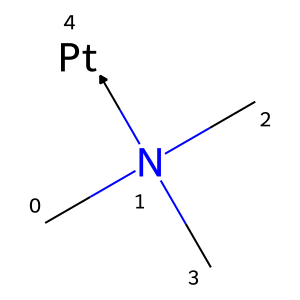

In [40]:
m = Chem.MolFromSmiles('CN(C)(C)[Pt]', sanitize=False)
m2 = set_dative_bonds(m)
m2

In [41]:
# we can check the bond between nitrogen and platinum
print(m2.GetBondBetweenAtoms(1,4).GetBondType())

DATIVE


### The SanitizeMol function

The SanitizeMol function (built into RDKit) allows us to check chemical validity of a molecule. Below are examples of how it can be used. More on https://www.programcreek.com/python/example/96360/rdkit.Chem.SanitizeMol 

In [40]:
def validate_rdkit_mol(mol):
    """
    Sanitizes an RDKit molecules and returns True if the molecule is chemically
    valid.
    :param mol: an RDKit molecule 
    :return: True if the molecule is chemically valid, False otherwise
    """

    if len(GetMolFrags(mol)) > 1:
        return False
    try:
        SanitizeMol(mol)
        return True
    except ValueError:
        return False 

In [41]:
validate_rdkit_mol(mol1)

True

In [53]:
GetMolFrags(mol2)

((0, 1, 2, 3, 4, 5, 6),)

### Basic Operations

In [64]:
mol2.GetNumAtoms() # gives number of non hydrogen atoms

7

In [65]:
mol2.GetNumBonds() # gives number of bonds between atoms, not counting hydrogens

7

In [68]:
my_list = mol2.GetAtoms()

In [73]:
[atom.GetSymbol() for atom in mol2.GetAtoms()] # if not atom.IsInRing()]

['C', 'C', 'C', 'C', 'C', 'C', 'C']

In [74]:
[atom.GetSymbol() for atom in mol2.GetAtoms() if not atom.IsInRing()]

['C']

In [75]:
mol2_with_hydrogens = Chem.AddHs(mol2)

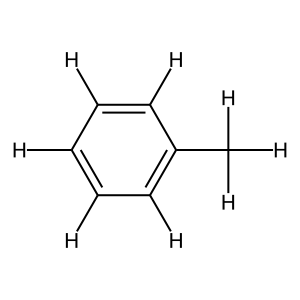

In [76]:
mol2_with_hydrogens

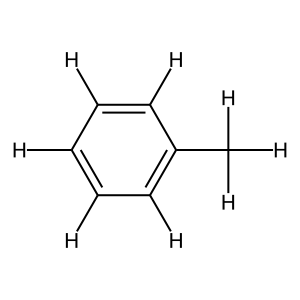

In [78]:
from rdkit.Chem import AllChem
AllChem.Compute2DCoords(mol2_with_hydrogens)
mol2_with_hydrogens

In [79]:
# descriptors are functions assigning numerical values to molecules
# example of a descriptor: compute number of atoms of a molecule, but more advanced descriptors exist as well
# example of use case for descriptors: can test all descriptors from Lipinski's Rule of Five

from rdkit.Chem import Descriptors
Descriptors.MolWt(mol2) #compues total molecular weight of all atoms in mol2

92.14099999999999

In [80]:
Descriptors.MolLogP(mol2) 
#not as reliable as MolWt because we can't measure this in a lab, it's predicted by an algorithm

1.99502

In [81]:
Descriptors.NumRotatableBonds(mol2)

0